# Modeling CPI - Structural breaks?
****
In the last file we have done SARIMA model on the clean data from 2020-01-01 on. It's been show, that it is possible to model the american Consumer Price Index with some kind of SARIMA-ARCH (the squared residuals did show serial autocorrelation). Conditional heteroskedasticity is not something we would like to have in the residuals of a predictive model however. Therefore let us see, whether there is any significant structural break in our dataset, which could help us cut off old observation and improve the fit of our models.

Let's start with importing and plotting the data again:

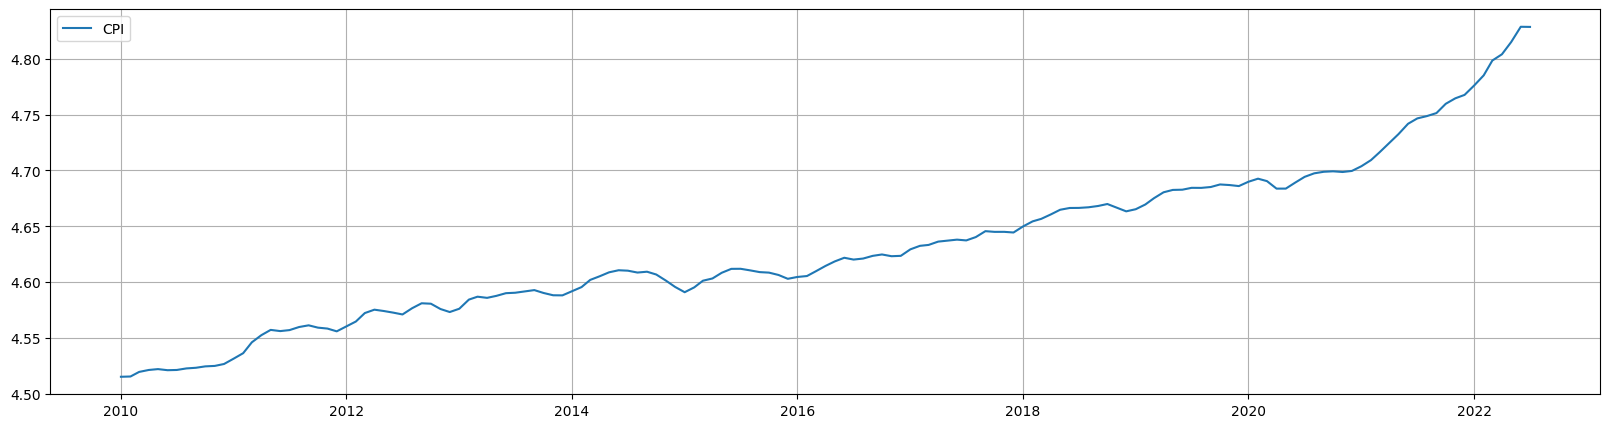

In [143]:
start = "2010-01-01"
data = np.log(FRED().get("USACPIALLMINMEI", observation_start=start))
data = pd.DataFrame({"CPI": data.values}, index=data.index)
diff = data.diff(1)[1:]

plt.figure(figsize=(20,5))
plt.grid()
plt.plot(data, label="CPI")
plt.legend()
plt.show()

If I was manually to choose the moment of structural break I would probably choose it somewhere between 2020 and 2021. Let's take a look at the differences as well:

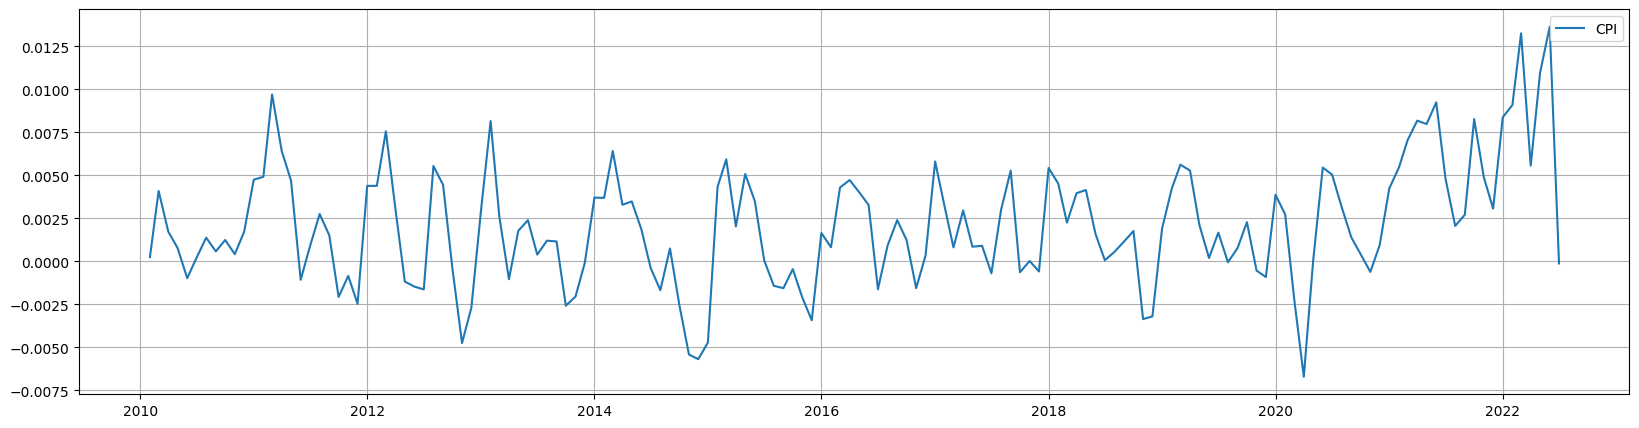

In [144]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(diff, label="CPI")
plt.legend()
plt.show()

#### Definitely there is some (stochastic?) trend at the end of the series.

**Purely visual estimation is dangerous however!** I'm going to use the PELT algorithm in both mean and mean-and-variance modes to see if it would confirm my conclusions:

In [101]:
%R -i data
%R -i diff

**At first let's check the differences in variance:**

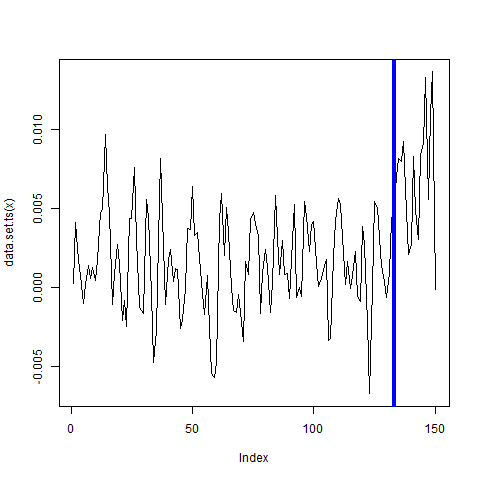

In [103]:
%%R

m.pelt_V=cpt.var(as.vector(diff$CPI),method='PELT')
plot(m.pelt,type="l",cpt.col="blue",xlab="Index",cpt.width=4)

**Okay - PELT for variance seems to confirm what we have just established. Let's run it again for mean-and-variance:**

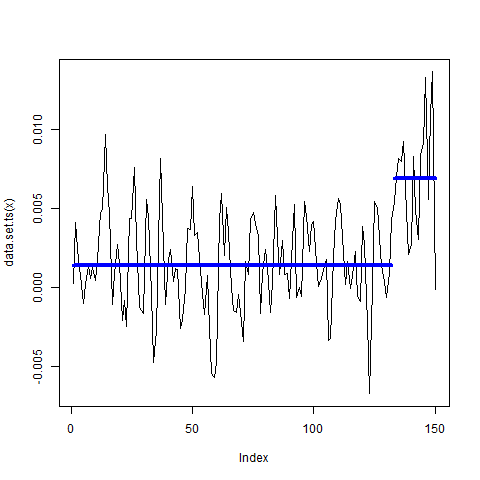

In [102]:
%%R

m.pelt_MV=cpt.meanvar(diff$CPI,method='PELT')
plot(m.pelt_MV,type="l",cpt.col="blue",xlab="Index",cpt.width=4)

Alright, both versions of PELT seem to agree. Let's just quickly print the output of the algorithm:

In [104]:
%%R
print(cpts(m.pelt_MV))
print(cpts(m.pelt_V))

[1] 132
[1] 133


The result is almost the same. Quantitatively makes sense then to separate the data at that point. Let's take a look at a plot of it:

In [117]:
pelt_data = data[130:]
pelt_diff = pelt_data.diff(1)[1:]
pelt_data

,CPI
2020-11-01,4.698600
2020-12-01,4.699541
2021-01-01,4.703786
2021-02-01,4.709246
2021-03-01,4.716304
2021-04-01,4.724489
2021-05-01,4.732474
2021-06-01,4.741722
2021-07-01,4.746521
2021-08-01,4.748585


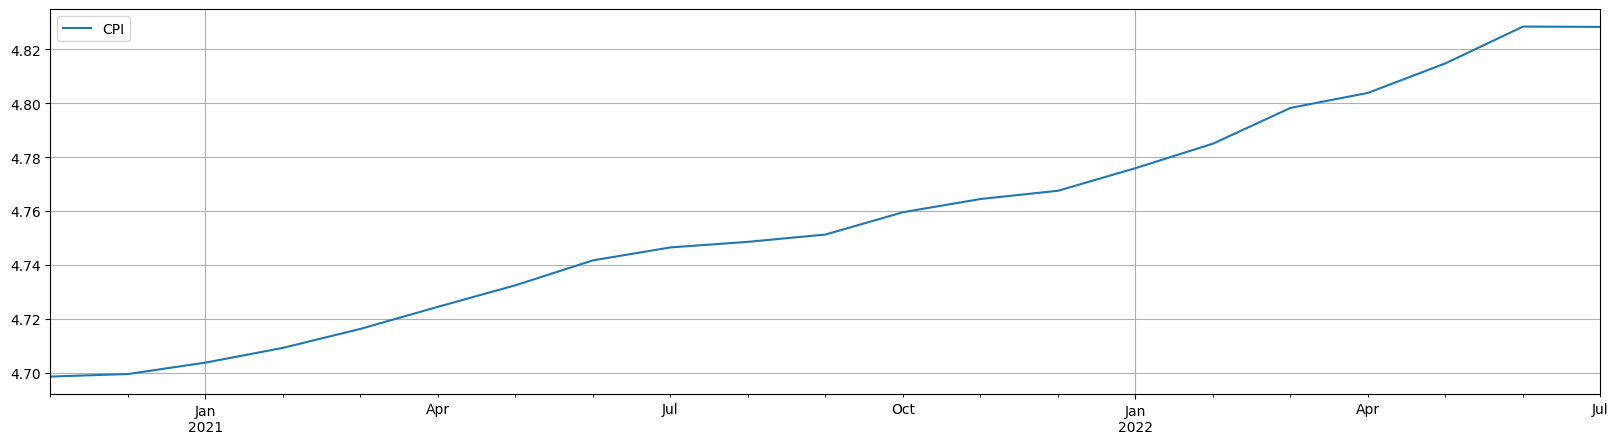

In [106]:
pelt_data.plot(figsize=(20,5))
plt.grid()

Okay this seems smooth!

There is one little problem however - **what is the actual reason for this structural change to have happened?** We cannot just say "well here it broke sir, let's call it a day". Structural changes have their reasons. In my opinion the reason for the structural break - not counting other macroeconomic factors that will be considered in another files also as multivariate analysis - was the outbreak of the pandemics. For the United States the real outbreak happened in April 2020, and so I'm going to adjust the new time series into its new date:

In [145]:
covid_data = data.loc["2020-04-01":]
covid_diff = covid_data.diff(1)[1:]
covid_data

,CPI
2020-04-01,4.683734
2020-05-01,4.683754
2020-06-01,4.689211
2020-07-01,4.694256
2020-08-01,4.697405
2020-09-01,4.698796
2020-10-01,4.699211
2020-11-01,4.698600
2020-12-01,4.699541
2021-01-01,4.703786


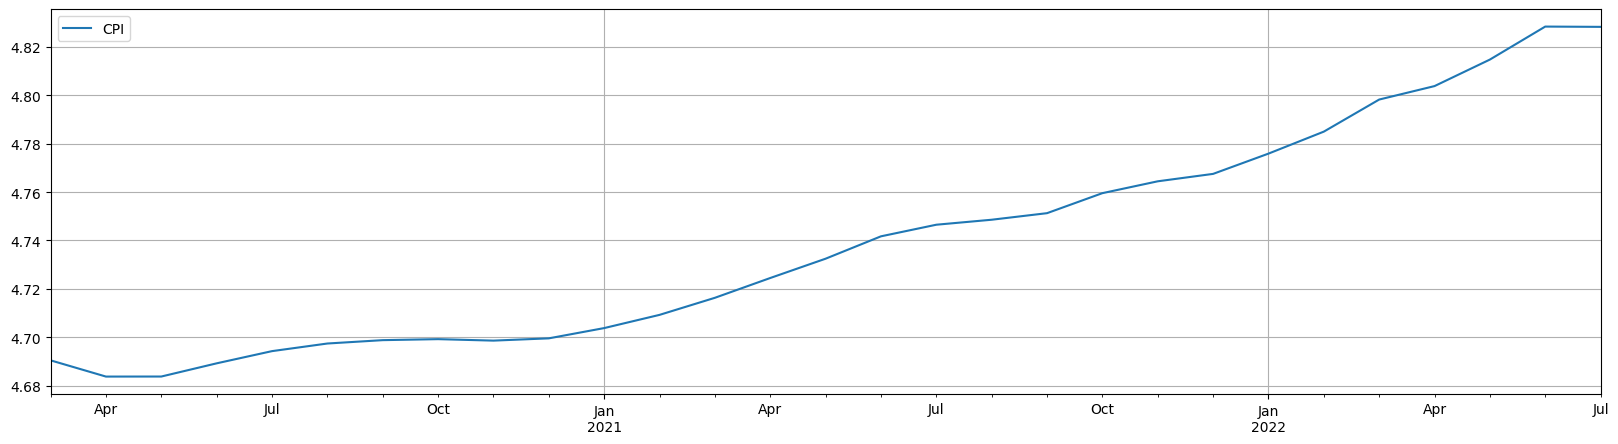

In [120]:
covid_data.plot(figsize=(20,5))
plt.grid()

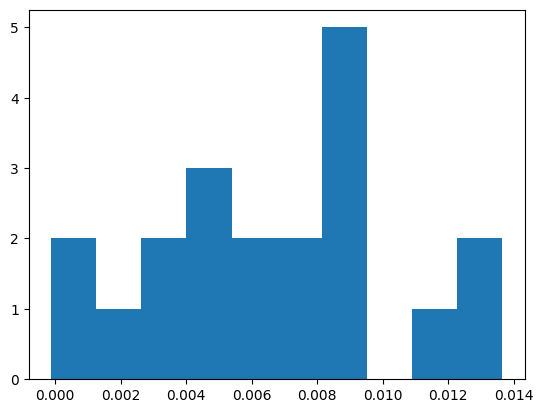

      Mean      Median    St. Dev.      Skew    Kurtosis    Durbin-Watson    JB-stat    JB-pvalue
----------  ----------  ----------  --------  ----------  ---------------  ---------  -----------
0.00648647  0.00631266  0.00381117  0.175689     2.50331         0.377828   0.458065     0.795303


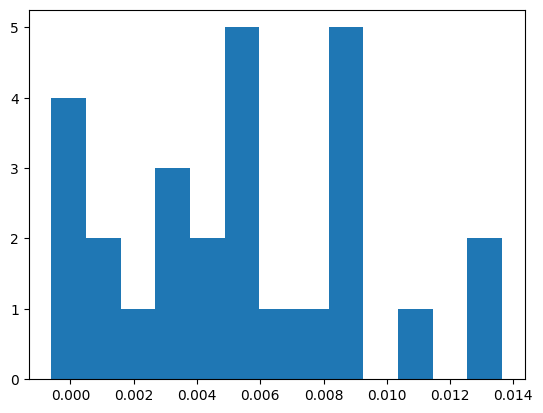

      Mean      Median    St. Dev.      Skew    Kurtosis    Durbin-Watson    JB-stat    JB-pvalue
----------  ----------  ----------  --------  ----------  ---------------  ---------  -----------
0.00535539  0.00504549  0.00397457  0.379589     2.48114         0.390725    1.04084     0.594271


In [175]:
functs.functs.descriptive(pelt_diff, bins=2)
functs.functs.descriptive(covid_diff, bins=2)

The distribution seems to be normal for both datasets. In such case, let's check their stationarity:

In [161]:
%R -i covid_diff
%R -i covid_diff
%R -i pelt_data
%R -i pelt_diff

In [178]:
%%R

print(adf.test(as.ts(pelt_data)))
print(kpss.test(as.ts(pelt_data)))
print("---------------------- diff ---------------------------")
print(adf.test(as.ts(pelt_diff)))
print(kpss.test(as.ts(pelt_diff)))


	Augmented Dickey-Fuller Test

data:  as.ts(pelt_data)
Dickey-Fuller = -1.4604, Lag order = 2, p-value = 0.7779
alternative hypothesis: stationary


	KPSS Test for Level Stationarity

data:  as.ts(pelt_data)
KPSS Level = 0.78802, Truncation lag parameter = 2, p-value = 0.01

[1] "---------------------- diff ---------------------------"

	Augmented Dickey-Fuller Test

data:  as.ts(pelt_diff)
Dickey-Fuller = -1.8397, Lag order = 2, p-value = 0.6334
alternative hypothesis: stationary


	KPSS Test for Level Stationarity

data:  as.ts(pelt_diff)
KPSS Level = 0.23449, Truncation lag parameter = 2, p-value = 0.1



In [122]:
%%R

print(adf.test(as.ts(covid_data)))
print(kpss.test(as.ts(covid_data)))
print("---------------------- diff ---------------------------")
print(adf.test(as.ts(covid_diff)))
print(kpss.test(as.ts(covid_diff)))


	Augmented Dickey-Fuller Test

data:  as.ts(covid_data)
Dickey-Fuller = -1.6166, Lag order = 3, p-value = 0.7196
alternative hypothesis: stationary


	KPSS Test for Level Stationarity

data:  as.ts(covid_data)
KPSS Level = 1.0225, Truncation lag parameter = 2, p-value = 0.01

[1] "---------------------- diff ---------------------------"

	Augmented Dickey-Fuller Test

data:  as.ts(covid_diff)
Dickey-Fuller = -3.0202, Lag order = 3, p-value = 0.1823
alternative hypothesis: stationary


	KPSS Test for Level Stationarity

data:  as.ts(covid_diff)
KPSS Level = 0.61046, Truncation lag parameter = 2, p-value = 0.02169



Interestingly, the PELT-based dataset seems not to be $I(0)$ and nor $I(1)$, however the COVID-based data is most likely $I(0)$ in the meaning of trend-stationarity.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


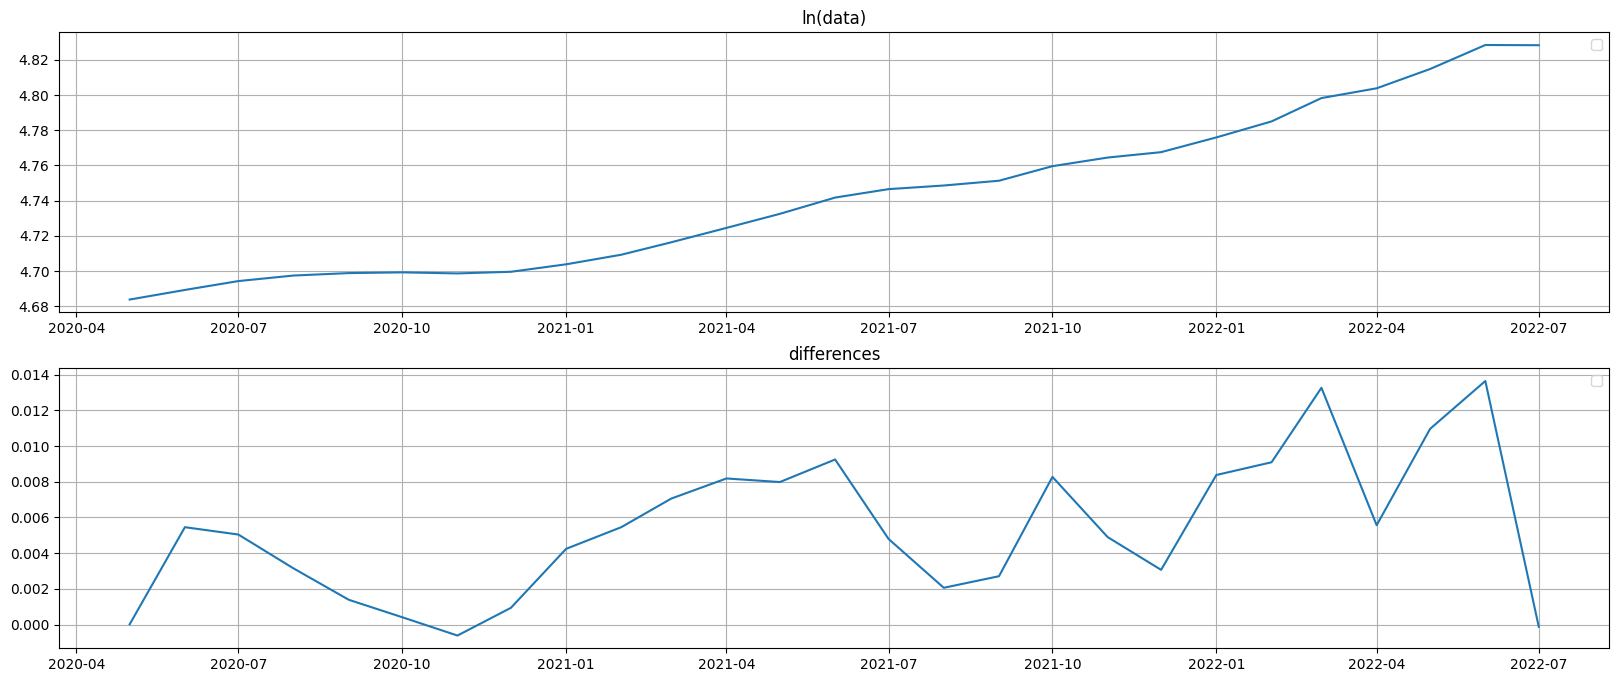

In [149]:
fig, ax = plt.subplots(2,1, figsize=(20,8))
ax[0].plot(covid_data[1:])
ax[0].grid()
ax[0].legend()
ax[0].title.set_text("ln(data)")
ax[1].plot(covid_diff)
ax[1].grid()
ax[1].legend()
ax[1].title.set_text("differences")
plt.show()

The COVID-based dataset is less smooth - that's true. In order to decide which dataset to use in further analysis, I'm going to simply check them both. Let's start with long memory:

In [153]:
%%R

print(fracdiff::fdGPH(pelt_data))
print(fracdiff::fdGPH(covid_data))

$d
[1] 0.9984163

$sd.as
[1] 0.6403275

$sd.reg
[1] 0.09976069

$d
[1] 0.9752333

$sd.as
[1] 0.5187023

$sd.reg
[1] 0.0659371



The $d$ parameters are nowhere between -0.5 and 0.5, which means that there is no long nor medium memory. Let's continue with ACF and PACF tests:

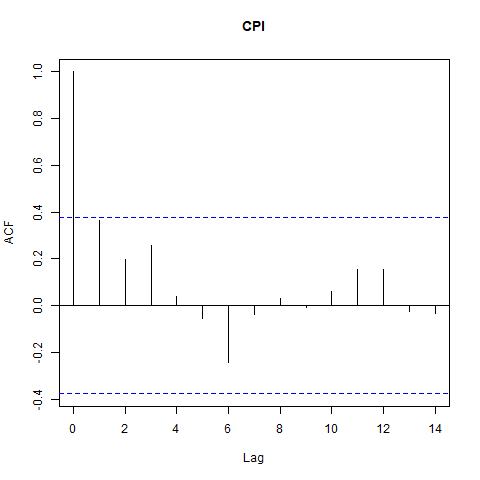

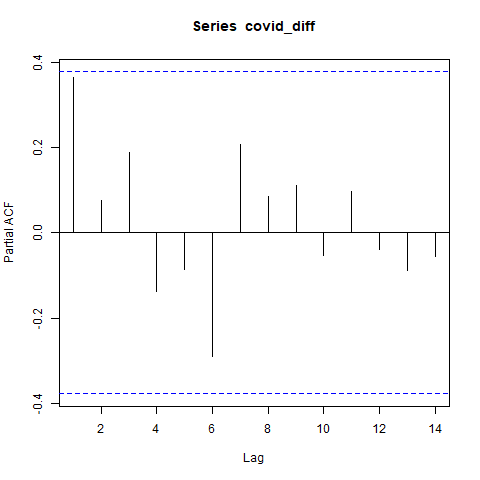

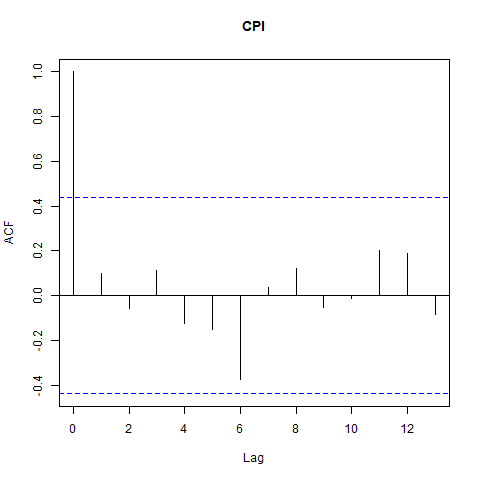

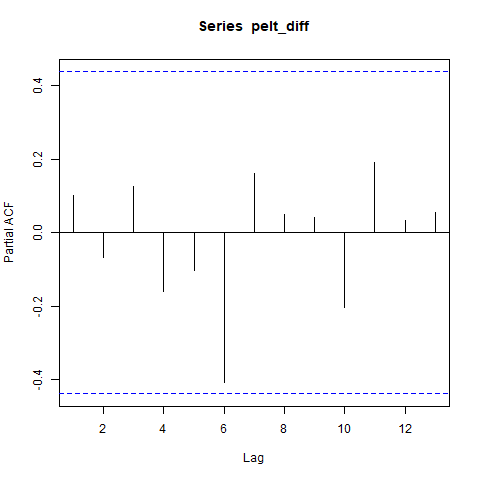

In [163]:
%%R
acf(covid_diff)
pacf(covid_diff)

acf(pelt_diff)
pacf(pelt_diff)

For ARIMA class of models it doesn't look too good, nevertheless the COVID-based dataset seems to be delicately more autocorrelated. The situation is unclear though, and so it is necessary however to run a formal test:

In [171]:
%%R

print(Box.test(pelt_diff$CPI))
print(Box.test(covid_diff$CPI))


	Box-Pierce test

data:  pelt_diff$CPI
X-squared = 0.20127, df = 1, p-value = 0.6537


	Box-Pierce test

data:  covid_diff$CPI
X-squared = 3.6006, df = 1, p-value = 0.05776



For $\alpha=0.05$ **both datasets don't show serial autocorrelation**. It's worth noting however that in case of COVID-based dataset the p-value is actually very close to $\alpha$, so if we change slightly the level of $\alpha$ we could think there is some autocorrelation. Nevertheless, doing it like "Well I don't like the result, let's change the result" would be irresponsible, so we are not going to do it like this. Instead of this we are going to run lagplots again and take the decision based on our experience:

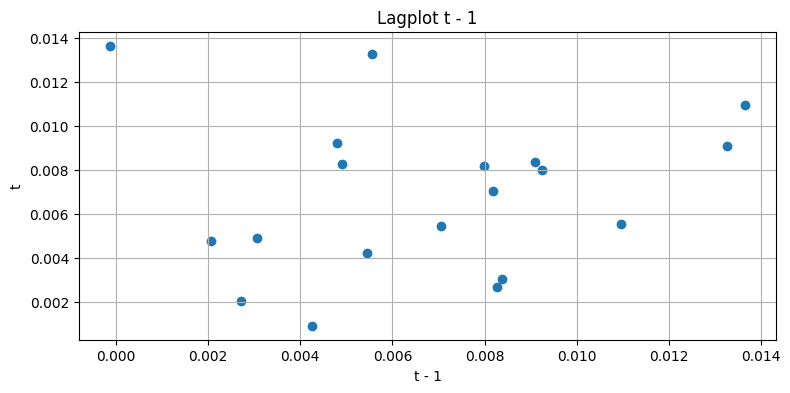

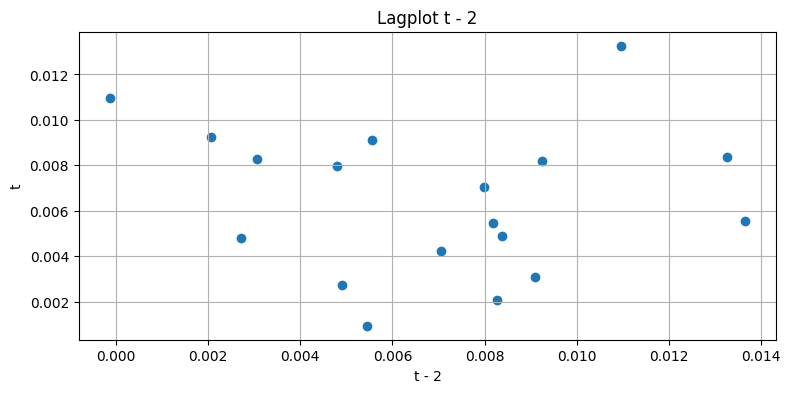

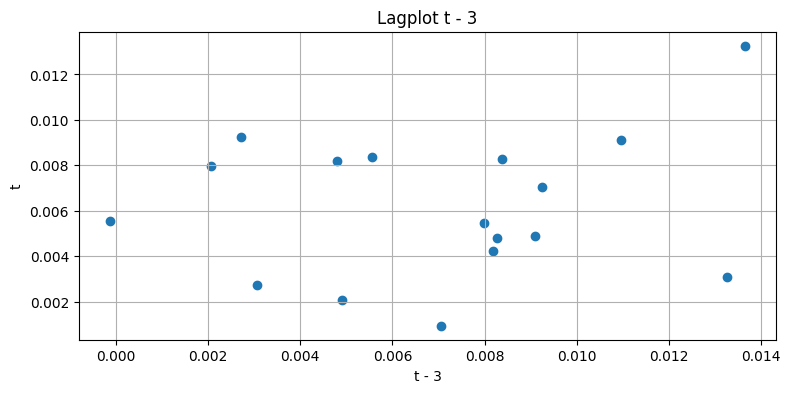

----------------------------- COVID ----------------------------------


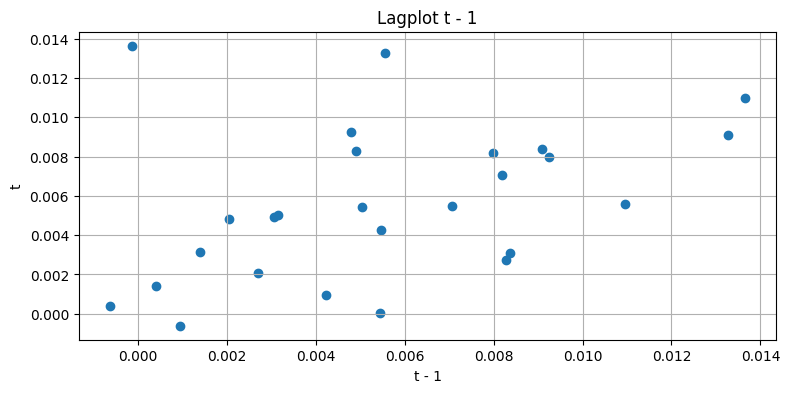

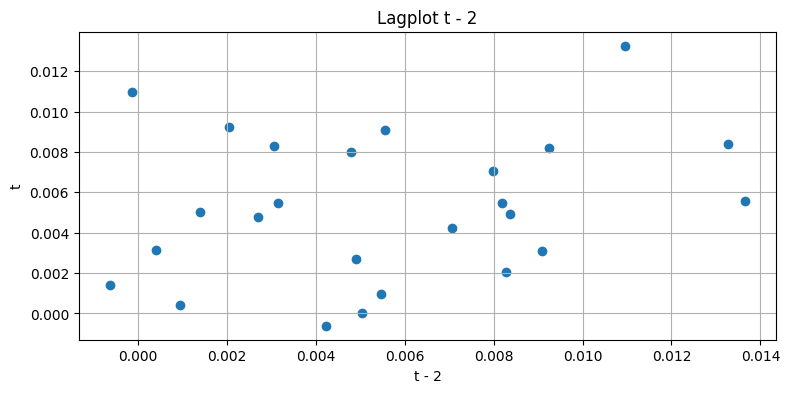

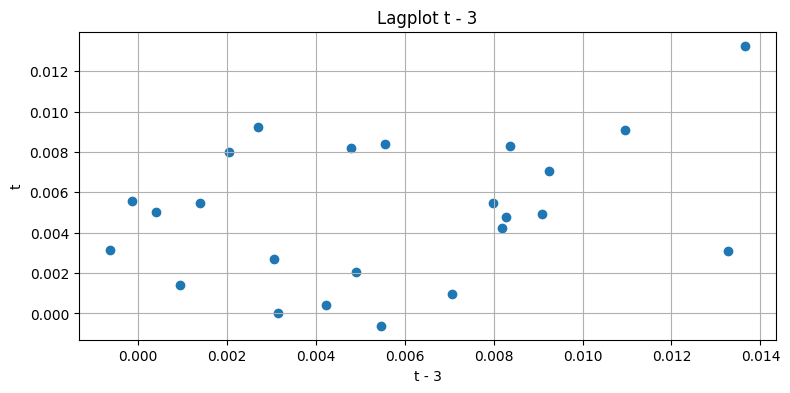

In [174]:
functs.functs.lag_plot(pelt_diff, 3)
print("----------------------------- COVID ----------------------------------")
functs.functs.lag_plot(covid_diff, 3)

**In my opinion, the above scatters indicate, that linear relationship for both datasets is existent**, however it's influenced by the outliers. Moreover, in case of the second lag it is possible that a quadratic relationship takes place - this indicates necessity of using nonlinear TSA techniques. Everything I have just mentioned makes me suspect, that **standard MLE or OLS based coefficient estimation might be inadequate** for (S)ARIMA, since OLS tends to overfit *"ugly"* datasets, or simply pay too much attention to the outliers.


Due to the fact, that in case of the COVID-based dataset the relationship is more visible, only this dataset will be taken into account during further analysis.

The next step will be checking seasonality:

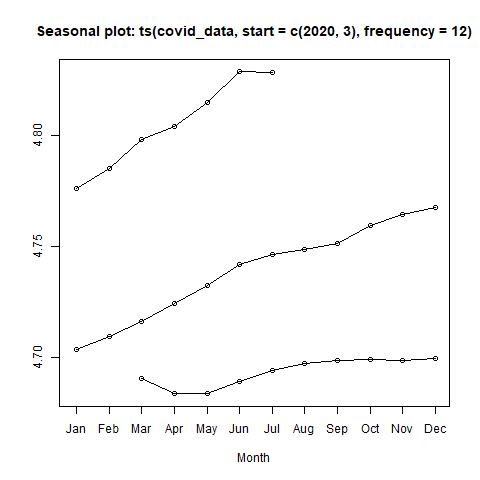

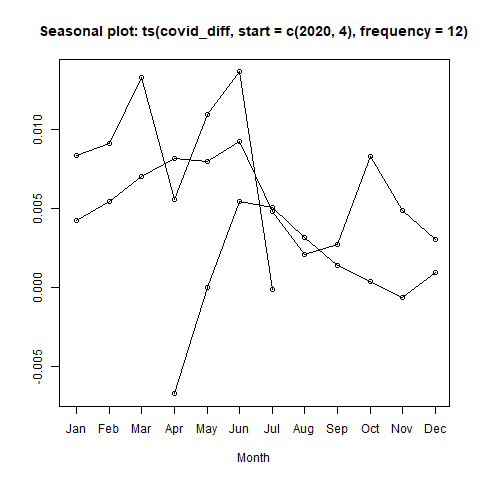

In [138]:
%%R

seasonplot(ts(covid_data, start=c(2020,04), frequency=12))
seasonplot(ts(covid_diff, start=c(2020,05), frequency=12))

The dataset is very short and it makes it difficult to say for certain whether seasonality really exists in this data or not. In my opinion however the downfall between June and August suggests that **there is**. Let's remember that seasonality indicates nonlinearity - that would match with the second lag scatterplot. But a decision like that cannot be based only on clues like this, so for now we assume the data is weakly linear and the hypothesis about possible nonlinear models will be tested in the future.

## Quick summary

Getting rid of structural breaks within the data might improve the overall performance of a model, however our probe **seems to be very short** - even too short. This does not mean that further analysis is pointless, but keep in mind, that the chances for success for such dataset are very low.

The series is assumed to exhibit linear and potentially nonlinear autocorrelation